# ECON240 (Regression), Fall 2021, Problem Set 4
Satej Soman, satej@berkeley.edu

---

# 0 Preliminaries: install packages, etc.

In [151]:
! pip3 install numpy pandas matplotlib statsmodels scipy tqdm

In [152]:
from io import BytesIO

import numpy as np
import pandas as pd
import requests
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from tqdm import tqdm

sns.set_theme(context = "notebook", palette = "bright")
plt.rc("axes.spines", top = False, right = False)
plt.rc("font", **{'family':'sans-serif', 'sans-serif':'Helvetica Neue'})
plt.rc('figure', dpi = 200)


## common functions (OLS and Bayesian Bootstrap)

In [120]:
# define OLS function to return point estimates, standard errors, and CI
def OLS(Y, X, W = 1, add_constant = True, α = 0.05):
    α = min(α, 1 - α)
    N = len(Y)
    regressors = list(X.columns)
    if add_constant: 
        X, regressors = np.c_[np.ones(X.shape[0]), X], ['intercept'] + regressors
    Γ_inv = np.linalg.inv((W * X.T) @ X)
    β = Γ_inv @ (W * X.T).dot(Y) 
    u = Y - X.dot(β)
    Ω = X.T.dot(X) * u.dot(u) / N
    Λ = Γ_inv @ Ω @ Γ_inv.T
    σ = np.sqrt(np.diag(Λ))
    q = stats.norm.ppf(1 - α / 2)
    output = pd.DataFrame(data = {
        "coefficient"   : β, 
        "standard error": σ,
        f"[{α/2}"       : β - q * σ, 
        f"{1-α/2}]"     : β + q * σ, 
}, index = regressors)
    output.vcv = ''; output.vcv = Λ  # monkeypatch the var-cov matrix into the output while suppressing pandas UserError
    return output



---

# 1      Linear regression (Example 1)

## 1. Least squares fit of `LogEarn` on (1, `HGC_Age28`)

In [121]:
# Download the data and restrict observations to ones where earnings > 0.
nsly_URL = "https://github.com/bryangraham/Ec240a/raw/master/Ec240a_Fall2021/Problem_Sets/nlsy79.csv"
nsly79   = pd.read_csv(nsly_URL).query("Earnings > 0")

In [122]:
Y = LogEarn   = np.log(nsly79["Earnings"])
X = HGC_Age28 = nsly79[["HGC_Age28"]]

OLS(Y, X)

,coefficient,standard error,[0.025,0.975]
intercept,8.591573,0.106173,8.383479,8.799668
HGC_Age28,0.162558,0.007845,0.147182,0.177934


In [123]:
sm.OLS(Y, sm.tools.add_constant(X), hasconst = True).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Earnings   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     428.9
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           4.30e-86
Time:                        22:38:12   Log-Likelihood:                -2398.1
No. Observations:                1906   AIC:                             4800.
Df Residuals:                    1904   BIC:                             4811.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5916      0.106     80.878      0.000       8.383       8.800
HGC_Age28      0.1626      0.008     20.710      0.000       0.147       0.178
==============================================================================
Omnibus:                     1303.659   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32441.197
Skew:                          -2.856   Prob(JB):                         0.00
Kurtosis:                      22.387   Cond. No.                         74.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**The StatsModels routine and the manually-implemented OLS agree in their point estimates and standard errors.**

## 2. Least squares fit of `LogEarn` on a constant, `HGC_Age28` and `AFQT`

We calculate a long regression (LR) of $Y$ = `LogEarn` on a constant, $X$ = `HGC_Age28` and $W$ = `AFQT`, and compare it to the short regression (SR) of `LogEarn` on a constant and `HGC_Age28`, as well as an auxiliary regression (AR) of `HGC_Age28` on `AFQT`. 

Long regression: $$ Y = \alpha_0 + X^\prime \beta_0 + W^\prime \gamma_0 $$ 
Short regression: $$ Y = X^\prime b_0 $$
Auxiliary regression: $$ W = \omega_0 + X^\prime \Pi_0 $$

Next, to express the SR coefficients in terms of the LR and AR results, construct the error vector in the long regression: $$U = Y - \mathbb{E}^*[ Y\ |\ X, W ]$$

By the Projection Theorem, this vector must be orthogonal to $X$, so:
$$\begin{align*}
\mathbb{E}^*[U\ |\ X ] &= 0 \\ 
\implies \mathbb{E}^*[Y\ |\ X] &= \alpha_0 + X^\prime \beta_0 + (\omega_0 + \Pi_0 X)^\prime \gamma_0 \\
&= \left( \alpha_0 + \omega_0^\prime \gamma_0  \right) + X^\prime(\beta_0 + \Pi_0^\prime \gamma_0) \\ 
\implies b_0 &= \beta_0 + \Pi_0^\prime \gamma_0
\end{align*}$$

We can then verify the coefficients align by running the regressions:

In [124]:
# long, short, and aux regressions
LR = OLS(Y, nsly79[["HGC_Age28", "AFQT"]])
SR = OLS(Y, nsly79[["HGC_Age28"]])
AR = OLS(nsly79["AFQT"], nsly79[["HGC_Age28"]])

print("long :\n", LR, "\n")
print("short:\n", SR, "\n")
print("aux  :\n", AR, "\n")

long :
            coefficient  standard error    [0.025    0.975]
intercept     8.915092        0.112372  8.694847  9.135336
HGC_Age28     0.108642        0.010345  0.088366  0.128918
AFQT          0.007072        0.000903  0.005302  0.008842 

short:
            coefficient  standard error    [0.025    0.975]
intercept     8.591573        0.106173  8.383479  8.799668
HGC_Age28     0.162558        0.007845  0.147182  0.177934 

aux  :
            coefficient  standard error     [0.025     0.975]
intercept   -45.745421        2.650927 -50.941142 -40.549700
HGC_Age28     7.623701        0.195878   7.239788   8.007615 



In [125]:
β = LR["coefficient"]["HGC_Age28"]
γ = LR["coefficient"]["AFQT"]
Π = AR["coefficient"]["HGC_Age28"]
b = SR["coefficient"]["HGC_Age28"]

print(β + Π*γ, "=", b)

0.16255788018545544 = 0.16255788018552053


**As expected, the short regression coefficients can be expressed in terms of the long regression and auxiliary regression coefficients.**

## 3. Single regression

We can express the coefficient on $\texttt{AFQT}$ by regressing $W = \texttt{AFQT}$ on $X = \texttt{HGCAge28}$, computing the residual $\widehat{W}$, and then regressing log-earnings on the residual.

In [126]:
W = nsly79["AFQT"]
Ŵ = (W - sm.tools.add_constant(X) @ AR["coefficient"].to_numpy()).to_frame()
RR = OLS(Y, Ŵ).rename(index = {0: "Ŵ"})
print(RR)
print(RR["coefficient"]["Ŵ"], "=", LR["coefficient"]["AFQT"])

           coefficient  standard error     [0.025     0.975]
intercept    10.754122        0.021313  10.712349  10.795894
Ŵ             0.007072        0.001002   0.005107   0.009037
0.00707214512723326 = 0.007072145127233309


As expected, the coefficient on the residual matches the coefficient of $\texttt{AFQT}$ in the long regression.

## 4. Extended regression

We want to fit the model: $ \mathbb{E}^*[\texttt{LogEarn}\,|\, \mathbf{X}] = \alpha_0 + \beta_0 \texttt{HGCAge28} + \gamma_0 \left(\texttt{HGCAge28} \times (\texttt{AFQT - 50})\right) + \delta_0 \texttt{AFQT}$, where $\mathbf{X} = (\texttt{HGCAge28}, \texttt{HGCAge28} \times (\texttt{AFQT - 50}), \texttt{AFQT})$.

In [127]:
# add interaction variable and run OLS
nsly79["HGC_Age28 × (AFQT - 50)"] = nsly79["HGC_Age28"] * (nsly79["AFQT"] - 50)
X_ = nsly79[["HGC_Age28", "AFQT", "HGC_Age28 × (AFQT - 50)"]]
model = OLS(Y, X_)
print(model)

                         coefficient  standard error    [0.025    0.975]
intercept                   8.654594        0.247242  8.170009  9.139179
HGC_Age28                   0.113838        0.011236  0.091817  0.135859
AFQT                        0.011238        0.003636  0.004111  0.018365
HGC_Age28 × (AFQT - 50)    -0.000331        0.000280 -0.000879  0.000217



### a. *Provide a semi-elasticity interpretation of $\beta_0$.*
Since the LHS is already in log-terms, $\beta_0$ is naturally interpretable as the average percentage change in earnings given an additional grade completed.

### b. *Provide a semi-elasticity interpretation of $\beta_0 + \gamma_0 (\texttt{AFQT} - 50)$.*
Similarly, $\beta_0 + \gamma_0 + (\texttt{AFQT} - 50)$ is the average percentage change in earnings given an additional grade completed, conditional on a given percentile of AFQT score.

### c. *Interpret the null hypothesis $H_0: \gamma_0 = 0$*
The null hypothesis in this case states that increased performance on the Armed Forces Qualification Test has no marginal affect on log-earnings, holding grade completion level constant.

### d., e. 
*see below*

In [153]:
# mean estimate 
afqt = np.linspace(0, 100, 100)
afqt_50 = afqt - 50
β0, γ0 = model.loc[["HGC_Age28", "HGC_Age28 × (AFQT - 50)"]]["coefficient"]
Z = β0 + γ0 * afqt_50

# asymptotic confidence intervals
V = model.vcv
σβ, σγ, K = V[1, 1], V[3, 3], V[1, 3]
qv = stats.norm.ppf(1 - 0.05 / 2) * np.sqrt(σβ + 2 * K * afqt_50 + σγ * afqt_50**2) # using formula for variance of linear combinations


# Bayesian bootstrap
np.random.seed(0)
n_bootstraps = 10000
bootstrapped = np.array([
    OLS(Y, X_, w/w.sum()).loc[["HGC_Age28", "HGC_Age28 × (AFQT - 50)"]]["coefficient"].values
    for w in tqdm(stats.gamma(1, 1).rvs((n_bootstraps, len(Y))))
])
βb, γb = bootstrapped.T

BB = np.sort(βb + γb * afqt_50[:, None], axis = 1)

100%|██████████| 10000/10000 [00:21<00:00, 467.43it/s]


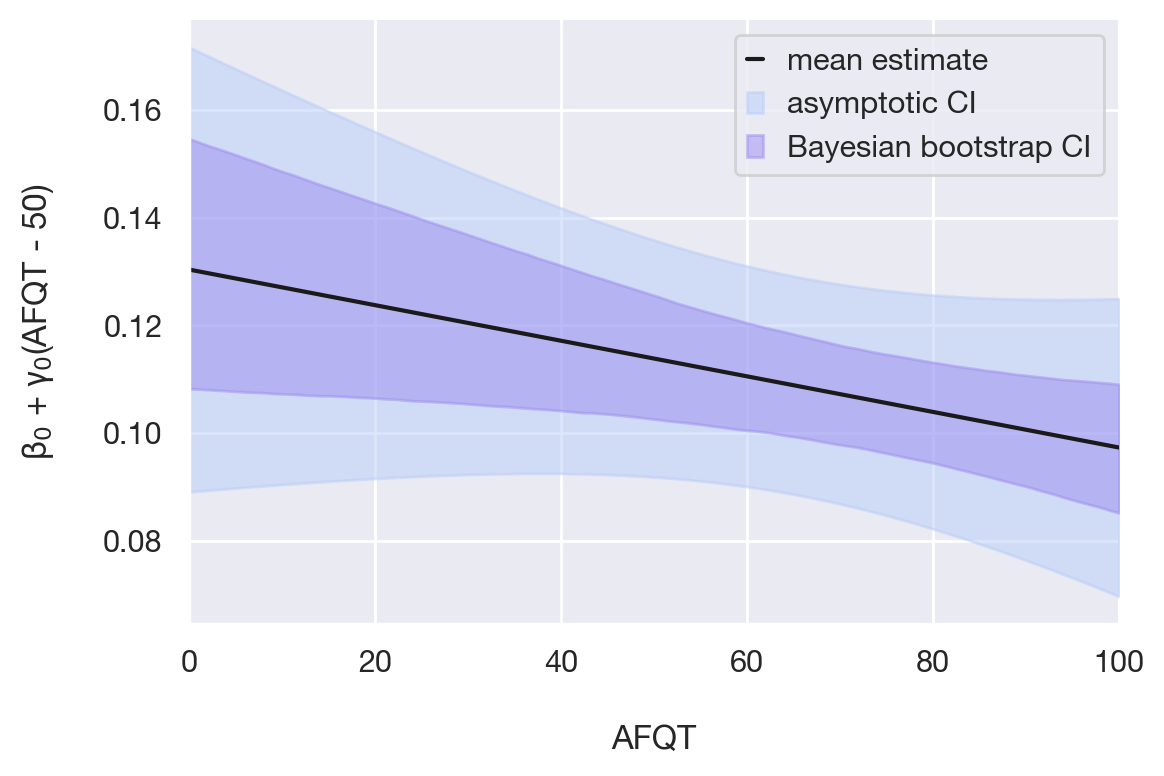

In [154]:
plt.plot(afqt, Z, "k", label = "mean estimate")

plt.fill_between(afqt, Z - qv, Z + qv , alpha = 0.5, color = "#B8CDF8", label = "asymptotic CI")
plt.fill_between(afqt, BB[:, int(0.025 * n_bootstraps)], BB[:, int(0.975 * n_bootstraps)], alpha = 0.5, color = "#9D8DF1", label = "Bayesian bootstrap CI")

plt.xlabel("\nAFQT")
plt.ylabel("β$_0$ + γ$_0$(AFQT - 50)\n")
plt.legend(handlelength = 0.5)
plt.xlim(0, 100)
plt.show()

### f. *Which confidence interval should we prefer?* 

The Bayesian bootstrap has a tighter confidence interval and does not rely on a homoskedasticity assumption.

---
---
---

## 2. Linear regression (Example 2)

In [130]:
pnad_url = "https://raw.githubusercontent.com/bryangraham/Ec240a/master/Ec240a_Fall2021/Problem_Sets/Brazil_1996PNAD.out"
pnad_content = requests.get(pnad_url).content
pnad = pd.read_csv(BytesIO(pnad_content), sep = "\t").query("MONTHLY_EARNINGS > 0")

### a. short regression + comparison to statsmodels

In [131]:
pnad["AgeInDays_sq"] = pnad.AgeInDays**2
X1 = ["YRSSCH", "AgeInDays", "AgeInDays_sq"]
pnad_SR = OLS(np.log(pnad.MONTHLY_EARNINGS), pnad[X1])
print(pnad_SR)

              coefficient  standard error    [0.025    0.975]
intercept        2.824276        0.020562  2.783975  2.864577
YRSSCH           0.145861        0.000743  0.144405  0.147318
AgeInDays        0.097871        0.001094  0.095726  0.100015
AgeInDays_sq    -0.000975        0.000013 -0.001001 -0.000949


In [136]:
print(sm.OLS(np.log(pnad.MONTHLY_EARNINGS), sm.tools.add_constant(pnad[X1]), hasconst = True).fit().summary())

                            OLS Regression Results                            
Dep. Variable:       MONTHLY_EARNINGS   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                 1.904e+04
Date:                Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:38:54   Log-Likelihood:                -77088.
No. Observations:               66506   AIC:                         1.542e+05
Df Residuals:                   66502   BIC:                         1.542e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.8243      0.021    137.350   

**The statsmodels implementation's point estimates, standard errors, and confidence intervals agree with the implementation from scratch developed in this assignment.** 

### b. long regression. 

In [133]:
schooling = lambda p: [f"{p}_{l}" for l in ["NoSchool", "Complete1stPrimary", "Complete2ndPrimary", "CompleteSecondary"]]
pnad_LR = OLS(np.log(pnad.MONTHLY_EARNINGS), pnad[X1 + schooling("Father") + schooling("Mother")])
print(pnad_LR)

                           coefficient  standard error    [0.025    0.975]
intercept                     2.799987        0.020869  2.759085  2.840889
YRSSCH                        0.138771        0.000843  0.137118  0.140424
AgeInDays                     0.099479        0.001125  0.097275  0.101684
AgeInDays_sq                 -0.000990        0.000014 -0.001016 -0.000963
Father_NoSchool              -0.045882        0.008762 -0.063054 -0.028709
Father_Complete1stPrimary     0.084424        0.010877  0.063106  0.105743
Father_Complete2ndPrimary    -0.038643        0.017994 -0.073911 -0.003375
Father_CompleteSecondary     -0.047070        0.019072 -0.084450 -0.009690
Mother_NoSchool              -0.005060        0.008670 -0.022053  0.011934
Mother_Complete1stPrimary     0.132640        0.011152  0.110783  0.154498
Mother_Complete2ndPrimary     0.125819        0.016924  0.092648  0.158990
Mother_CompleteSecondary      0.177586        0.018306  0.141706  0.213466


The coefficient on $\texttt{YRSSCH}$ is reduced when controlling for parents' schooling levels, indicating an omitted variable bias, which is reasonable since we may expect children's schooling to increase with parents' schooling.

### c. residual regression

As before, we will regress $Q = \texttt{YRSSCH}$ on the other covariates, construct the residual, and regression log-monthly-earnings on the residual.

In [134]:
Q = pnad.YRSSCH
pnad_X = X1[1:] + schooling("Father") + schooling("Mother")
pnad_AR = OLS(Q, pnad[pnad_X])
Q_ = (Q - sm.tools.add_constant(pnad[pnad_X]) @ pnad_AR["coefficient"].to_numpy()).to_frame()

pnad_RR = OLS(np.log(pnad.MONTHLY_EARNINGS), Q_).rename(index = {0: "Q_"})
print(pnad_RR)
print(pnad_RR["coefficient"]["Q_"], "=", pnad_LR["coefficient"]["YRSSCH"])

           coefficient  standard error    [0.025    0.975]
intercept     5.731608        0.003608  5.724537  5.738679
Q_            0.138771        0.001022  0.136767  0.140774
0.1387708596090905 = 0.1387708596090862


As expected, the results from the residual regression match those of the long regression.

### d. Bayesian bootstrap vs. asymptotic confidence interval.

In [156]:
# running Bayesian bootstrap for both regressions: 
np.random.seed(0)
n_bootstraps = 10000
Xs = pnad[X1]
Xl = pnad[X1 + schooling("Father") + schooling("Mother")]
bootstrapped = np.array([
    [
        OLS(np.log(pnad.MONTHLY_EARNINGS), Xs, w/w.sum()).loc[["YRSSCH"]]["coefficient"].values, 
        OLS(np.log(pnad.MONTHLY_EARNINGS), Xl, w/w.sum()).loc[["YRSSCH"]]["coefficient"].values, 
    ]
    for w in tqdm(stats.gamma(1, 1).rvs((n_bootstraps, len(np.log(pnad.MONTHLY_EARNINGS)))))
])[:, :, 0]
βs, βl = bootstrapped.T

100%|██████████| 10000/10000 [07:49<00:00, 21.31it/s]


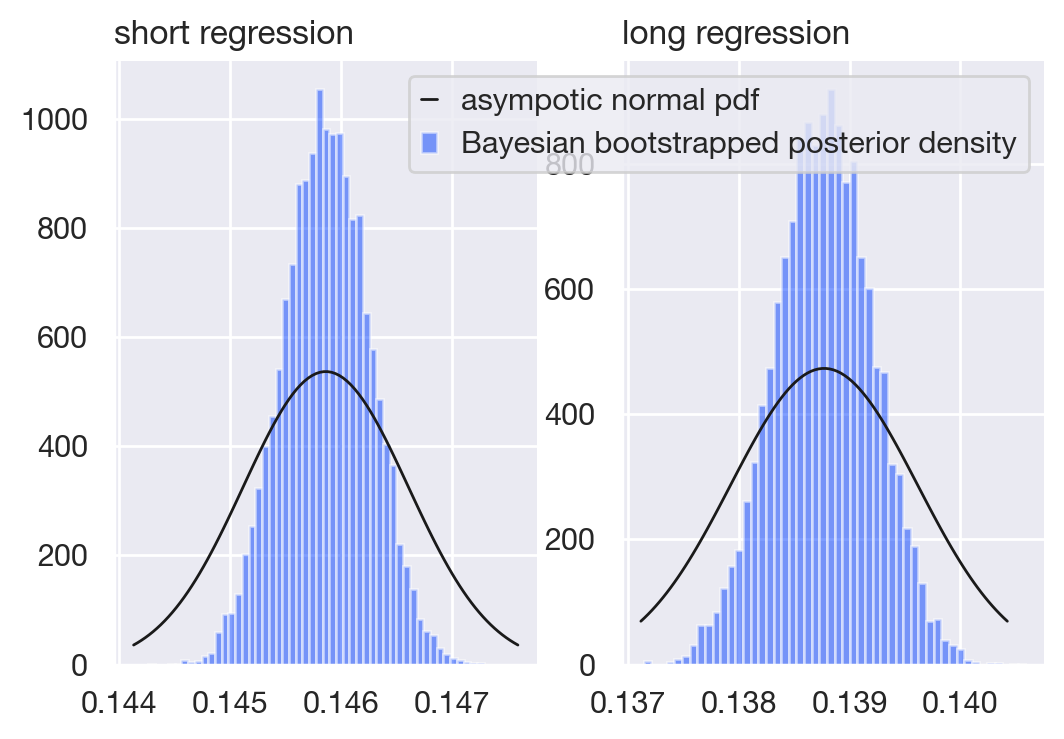

In [204]:
n_bins = 50
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.hist(βs, bins = n_bins, alpha = 0.5, label = "Bayesian bootstrapped posterior density", density = True)
Ns = stats.norm(pnad_SR["coefficient"]["YRSSCH"], pnad_SR["standard error"]["YRSSCH"])
x = np.linspace(Ns.ppf(0.01), Ns.ppf(0.99), 100)
plt.plot(x, Ns.pdf(x), 'k-', lw = 1, label='asympotic normal pdf')
plt.title("short regression", loc = "left")

plt.sca(ax2)
plt.hist(βl, bins = n_bins, alpha = 0.5, label = "Bayesian bootstrapped posterior density", density = True)
Nl = stats.norm(pnad_LR["coefficient"]["YRSSCH"], pnad_LR["standard error"]["YRSSCH"])
x = np.linspace(Nl.ppf(0.025), Nl.ppf(0.975), 100)
plt.plot(x, Nl.pdf(x), 'k-', lw = 1, label='asympotic normal pdf')
plt.title("long regression", loc = "left")

plt.legend(handlelength = 0.5)
plt.show()

The Bayesian bootstrap posterior has a tighter density around the mean than the asymptotic estimate does.